In [ ]:
# =============================================================================
# DexUMI HDF5 Data Structure Analysis & Visualization
# =============================================================================

## 📦 Import Dependencies

## 📊 Data Structure Overview

In [1]:
from pathlib import Path
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Open HDF5 file
path = Path('/home/unitree/桌面/umi2lerobot/rawData/DexWild/spray_data/human/human_spray_data.hdf5')
f = h5py.File(path, 'r')
# ========== Episode Statistics ==========
all_episodes = list(f.keys())
print(f'\n{"="*60}')
print(f'🎬 Total Episodes: {len(all_episodes)}')
print(f'📁 Episode Range: {all_episodes[0]} ~ {all_episodes[-1]}')
print(f'{"="*60}\n')

# ========== Single Episode Structure ==========
ep = f['ep_0200']
print(f'📂 ep_0001 Top-level Keys: {list(ep.keys())}\n')

# Collect data info
data_info = []
for key in ep.keys():
    item = ep[key]
    if isinstance(item, h5py.Group):
        subkeys = list(item.keys())
        sample = item[subkeys[0]]
        if len(sample.shape) == 3:  # Image
            data_info.append({
                'Field': f'📷 {key}',
                'Type': 'Image Sequence',
                'Count/Shape': f'{len(subkeys)} frames',
                'Frame Size': f'{sample.shape}',
                'Data Type': str(sample.dtype)
            })
        else:  # Numeric data
            for subkey in subkeys:
                subitem = item[subkey]
                data_info.append({
                    'Field': f'🦾 {key}/{subkey}',
                    'Type': 'Numeric Sequence',
                    'Count/Shape': str(subitem.shape),
                    'Frame Size': f'{subitem.shape[1]}D' if len(subitem.shape) > 1 else 'Scalar',
                    'Data Type': str(subitem.dtype)
                })

# Display with pandas
df = pd.DataFrame(data_info)
display(HTML('<h4>🗂️ ep_0001 Detailed Data Structure</h4>'))
display(df.style.set_properties(**{'text-align': 'left'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left'), ('background-color', '#4a4a4a'), ('color', 'white')]}]
))


🎬 Total Episodes: 2820
📁 Episode Range: ep_0000 ~ ep_2819

📂 ep_0001 Top-level Keys: ['head_cam', 'right_leapv2', 'right_manus', 'right_pinky_cam', 'right_thumb_cam', 'right_tracker', 'timesteps', 'zed', 'zed_obs']



,Field,Type,Count/Shape,Frame Size,Data Type
0,📷 head_cam,Image Sequence,244 frames,"(240, 320, 3)",uint8
1,🦾 right_leapv2/right_leapv2,Numeric Sequence,"(244, 18)",18D,float64
2,🦾 right_manus/right_manus,Numeric Sequence,"(244, 71)",71D,float64
3,📷 right_pinky_cam,Image Sequence,245 frames,"(240, 320, 3)",uint8
4,📷 right_thumb_cam,Image Sequence,245 frames,"(240, 320, 3)",uint8
5,🦾 right_tracker/head_right_tracker,Numeric Sequence,"(244, 8)",8D,float64
6,🦾 right_tracker/right_tracker.png,Numeric Sequence,"(480, 640, 4)",640D,uint8
7,🦾 right_tracker/right_tracker_world,Numeric Sequence,"(244, 8)",8D,float64
8,🦾 right_tracker/tracker_comparison.png,Numeric Sequence,"(480, 640, 4)",640D,uint8
9,🦾 right_tracker/zed_right_tracker,Numeric Sequence,"(244, 8)",8D,float64


In [ ]:
value = ep["zed"]["zed_ts"][1,1]
print(f'{value:.0f}') 

1745435177084632576


In [6]:
print(list(ep["right_pinky_cam"].keys())[:10])

['1744816534408447232.jpg', '1744816534441747712.jpg', '1744816534472974848.jpg', '1744816534508429824.jpg', '1744816534541141504.jpg', '1744816534575174144.jpg', '1744816534608448256.jpg', '1744816534641746432.jpg', '1744816534675040768.jpg', '1744816534708386048.jpg']


## 📈 Episode Frame Count Statistics

In [ ]:
# Count frames per episode
frame_counts = []
for ep_key in all_episodes:
    ep = f[ep_key]
    possible_cam_keys = ['zed_obs', 'left_pinky_cam', 'right_pinky_cam', 'left_thumb_cam', 'right_thumb_cam']
    n_frames = 0
    for cam_key in possible_cam_keys:
        if cam_key in ep:
            n_frames = len(list(ep[cam_key].keys()))
            break
    if n_frames == 0:
        for key in ep.keys():
            item = ep[key]
            if isinstance(item, h5py.Group):
                for subkey in item.keys():
                    subitem = item[subkey]
                    if hasattr(subitem, 'shape') and len(subitem.shape) >= 1:
                        n_frames = subitem.shape[0]
                        break
            if n_frames > 0:
                break
    frame_counts.append(n_frames)

# Plot frame distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram
axes[0].hist(frame_counts, bins=30, color='#4CAF50', edgecolor='white', alpha=0.8)
axes[0].axvline(np.mean(frame_counts), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(frame_counts):.1f}')
axes[0].set_xlabel('Frame Count', fontsize=12)
axes[0].set_ylabel('Episode Count', fontsize=12)
axes[0].set_title('Episode Frame Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Right: Line plot
axes[1].plot(range(len(frame_counts)), frame_counts, color='#2196F3', linewidth=1, alpha=0.7)
axes[1].fill_between(range(len(frame_counts)), frame_counts, alpha=0.3, color='#2196F3')
axes[1].set_xlabel('Episode Index', fontsize=12)
axes[1].set_ylabel('Frame Count', fontsize=12)
axes[1].set_title('Frame Count per Episode', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f'\nFrame Statistics:')
print(f'   Min: {min(frame_counts)}')
print(f'   Max: {max(frame_counts)}')
print(f'   Mean: {np.mean(frame_counts):.1f}')
print(f'   Total: {sum(frame_counts)}')

## 📷 Camera Views Preview

In [ ]:
# Show available camera views
ep = f['ep_0001']
all_cameras = ['left_pinky_cam', 'left_thumb_cam', 'right_pinky_cam', 'right_thumb_cam', 'zed_obs']
all_labels = ['Left Pinky Cam', 'Left Thumb Cam', 'Right Pinky Cam', 'Right Thumb Cam', 'ZED Main Cam']

# Filter existing cameras
cameras = [cam for cam in all_cameras if cam in ep]
camera_labels = [all_labels[all_cameras.index(cam)] for cam in cameras]

if len(cameras) > 0:
    fig, axes = plt.subplots(1, len(cameras), figsize=(4*len(cameras), 4))
    if len(cameras) == 1:
        axes = [axes]
    
    for i, (cam, label) in enumerate(zip(cameras, camera_labels)):
        cam_group = ep[cam]
        first_key = sorted(cam_group.keys())[0]
        img = cam_group[first_key][:]
        
        axes[i].imshow(img)
        axes[i].set_title(label, fontsize=10, fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle('ep_0001 Frame 1 - Camera Views', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print('No camera data found in ep_0001')

## 🤖 Intergripper Image Visualization

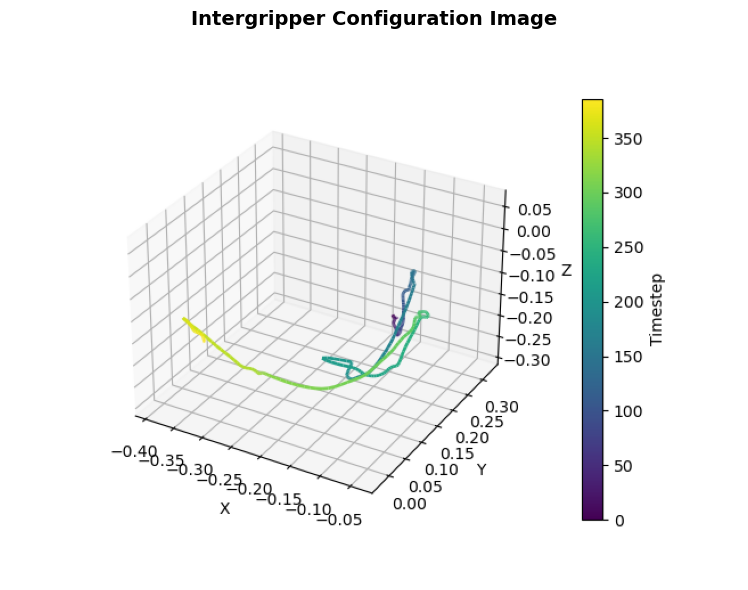


Intergripper Image Info:
   Shape: (480, 640, 4)
   Dtype: uint8


In [5]:
# Visualize intergripper.png
ep = f['ep_0001']


intergripper_img = ep['right_tracker']['right_tracker_world_clipped.png'][:]
# right_tracker/right_tracker_world_clipped.png
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Check if image has alpha channel (RGBA)
if intergripper_img.shape[-1] == 4:
    ax.imshow(intergripper_img)
else:
    ax.imshow(intergripper_img)

ax.set_title('Intergripper Configuration Image', fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

print(f'\nIntergripper Image Info:')
print(f'   Shape: {intergripper_img.shape}')
print(f'   Dtype: {intergripper_img.dtype}')


## 🦾 Arm Action Data Visualization

In [ ]:
# Visualize bimanual end-effector data
ep = f['ep_0001']

has_left_eef = 'left_arm_eef' in ep and 'left_arm_eef' in ep['left_arm_eef']
has_right_eef = 'right_arm_eef' in ep and 'right_arm_eef' in ep['right_arm_eef']

if has_left_eef and has_right_eef:
    left_eef = ep['left_arm_eef']['left_arm_eef'][:]
    right_eef = ep['right_arm_eef']['right_arm_eef'][:]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    
    # Left arm position (first 3 dims)
    axes[0, 0].plot(left_eef[:, 0], label='X', alpha=0.8)
    axes[0, 0].plot(left_eef[:, 1], label='Y', alpha=0.8)
    axes[0, 0].plot(left_eef[:, 2], label='Z', alpha=0.8)
    axes[0, 0].set_title('Left Arm EEF Position (XYZ)', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Left arm orientation (last 4 dims)
    axes[0, 1].plot(left_eef[:, 3:7], alpha=0.8)
    axes[0, 1].set_title('Left Arm EEF Orientation (Quaternion)', fontweight='bold')
    axes[0, 1].legend(['qw', 'qx', 'qy', 'qz'])
    axes[0, 1].grid(alpha=0.3)
    
    # Right arm position
    axes[1, 0].plot(right_eef[:, 0], label='X', alpha=0.8)
    axes[1, 0].plot(right_eef[:, 1], label='Y', alpha=0.8)
    axes[1, 0].plot(right_eef[:, 2], label='Z', alpha=0.8)
    axes[1, 0].set_title('Right Arm EEF Position (XYZ)', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Right arm orientation
    axes[1, 1].plot(right_eef[:, 3:7], alpha=0.8)
    axes[1, 1].set_title('Right Arm EEF Orientation (Quaternion)', fontweight='bold')
    axes[1, 1].legend(['qw', 'qx', 'qy', 'qz'])
    axes[1, 1].grid(alpha=0.3)
    
    plt.suptitle('ep_0001 Bimanual End-Effector Trajectories', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print('Bimanual EEF data not found in ep_0001')
    print(f'   left_arm_eef exists: {has_left_eef}')
    print(f'   right_arm_eef exists: {has_right_eef}')

## ✋ LEAP Hand Tracking Visualization

In [ ]:
# Visualize LEAP hand data
ep = f['ep_0001']

has_left_leap = 'left_leapv2' in ep and 'left_leapv2' in ep['left_leapv2']
has_right_leap = 'right_leapv2' in ep and 'right_leapv2' in ep['right_leapv2']

if has_left_leap and has_right_leap:
    left_leap = ep['left_leapv2']['left_leapv2'][:]
    right_leap = ep['right_leapv2']['right_leapv2'][:]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left hand heatmap
    im1 = axes[0].imshow(left_leap.T, aspect='auto', cmap='viridis')
    axes[0].set_title('Left Hand LEAP Data (18D)', fontweight='bold')
    axes[0].set_xlabel('Time Frame')
    axes[0].set_ylabel('Joint Dimension')
    plt.colorbar(im1, ax=axes[0])
    
    # Right hand heatmap
    im2 = axes[1].imshow(right_leap.T, aspect='auto', cmap='viridis')
    axes[1].set_title('Right Hand LEAP Data (18D)', fontweight='bold')
    axes[1].set_xlabel('Time Frame')
    axes[1].set_ylabel('Joint Dimension')
    plt.colorbar(im2, ax=axes[1])
    
    plt.suptitle('ep_0001 Bimanual LEAP Hand Tracking Heatmap', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f'\nLEAP Data Shape:')
    print(f'   Left Hand: {left_leap.shape}')
    print(f'   Right Hand: {right_leap.shape}')
else:
    print('LEAP hand data not found in ep_0001')
    print(f'   left_leapv2 exists: {has_left_leap}')
    print(f'   right_leapv2 exists: {has_right_leap}')

## 🔚 Close File Handle

In [ ]:
# Close file when done
# f.close()